In [1]:
import os
import sys
import datetime
import numpy as np
import skimage.draw
import SimpleITK as sitk
import matplotlib.pylab as plt
from imgaug import augmenters as iaa



# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.visualize import display_images

# Path to trained weights file
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [2]:
class CamusDataset(utils.Dataset):
    
    def load_camus_images(self, dataset_dir,subset,test=0):
        """Load a subset of the dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        
        ratio_VALIDATION=0.8
        # Add classes. We have 1 classe and backround is initialized per default
        self.add_class("camus", 1, "left ventricule")
        if(test):
            dataset_dir = os.path.join(dataset_dir, "camus_test")
        else:
            assert subset in ["train", "validation"]
            if subset=="train":
                dataset_dir = os.path.join(dataset_dir, "camus_separated")
            else:
                dataset_dir = os.path.join(dataset_dir, "camus_separated")
        #Path to mhd images (not gt)
        print(dataset_dir)
        image_ids = []
        # r=root, d=directories, f = files
       
        
        for r, d, f in os.walk(dataset_dir):
            for file in f:    
                if ('ED.mhd' in file) or ('ES.mhd' in file):
                    image_ids.append(os.path.join(r, file))
        numImages=len(image_ids)
        
        
        #stopCount=int(ratio_VALIDATION*numImages)
        stopCount=numImages-200
        print(numImages)
        if subset=="train":
            for image_id in image_ids[:stopCount]:                
                self.add_image(
                    "camus",
                    image_id=image_id[29:48],
                    path=image_id)
        elif subset=="validation":
            for image_id in image_ids[stopCount:]:                
                self.add_image(
                    "camus",
                    image_id=image_id[29:48],
                    path=image_id)
            
    def load_mask(self, image_id):
        #dataset_dir = "/floyd/input/"#*******************************************************change !!!!!!!!!!!!!!!!!!!!!!!!!!
        info = self.image_info[image_id]
        #mask1_dir = os.path.join(os.path.dirname(info['path']),info['id']+"_gt.mhd")
        mask1_dir = (info['path'][:-4]+"_gt1.mhd")
        
        mask1=sitk.GetArrayFromImage(sitk.ReadImage(mask1_dir, sitk.sitkFloat32))
        #mask1=mask1[0,:,:]
        if DEBUG:
            print(dataset_dir)
            print("mask direction"+str(mask1_dir))
            print("path"+str(info['path']))
            print("info"+str(info['id']))
            print("shape"+str(mask1.shape))
        mask1=np.expand_dims(mask1, axis=2)
        return mask1, np.arange(1,2, dtype=np.int32)#class_ids.astype(np.int32)
        
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "camus":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
    
    def load_image (self, image_id):
        image=sitk.GetArrayFromImage(sitk.ReadImage(self.image_info[image_id]['path'], sitk.sitkFloat32))
        image=image[0,:,:]
        image=image[..., np.newaxis]
        #image=np.expand_dims(image, axis=2)
        return image
    
    

/floyd/input/camus_separated
1800
/floyd/input/camus_separated
1800
Image Count: 1600
Class Count: 2
  0. BG                                                
  1. left ventricule                                   
True
(1600,)
0
1599
image shape:(908, 551, 1)
/floyd/input
mask direction/floyd/input/camus_separated/patient0237/patient0237_2CH_ED_gt1.mhd
path/floyd/input/camus_separated/patient0237/patient0237_2CH_ED.mhd
infopatient0237/patient
shape(908, 551)
mask shape:(908, 551, 1)
[   0    1    2 ... 1597 1598 1599]
426
image mean: 54.348297
/floyd/input
mask direction/floyd/input/camus_separated/patient0432/patient0432_2CH_ED_gt1.mhd
path/floyd/input/camus_separated/patient0432/patient0432_2CH_ED.mhd
infopatient0432/patient
shape(779, 472)
(779, 472, 1)
mask shape(779, 472, 1)


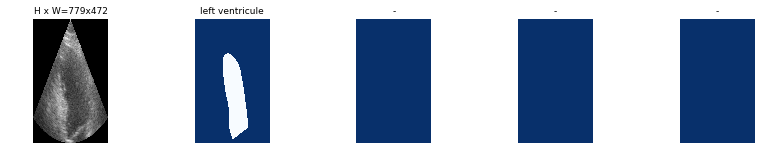

635
image mean: 50.81497
/floyd/input
mask direction/floyd/input/camus_separated/patient0047/patient0047_4CH_ES_gt1.mhd
path/floyd/input/camus_separated/patient0047/patient0047_4CH_ES.mhd
infopatient0047/patient
shape(843, 512)
(843, 512, 1)
mask shape(843, 512, 1)


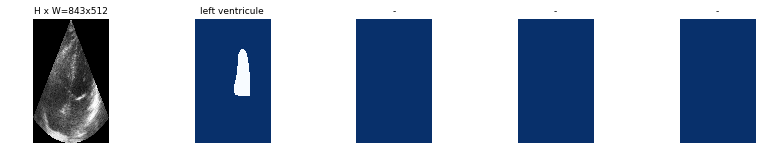

273
image mean: 45.038464
/floyd/input
mask direction/floyd/input/camus_separated/patient0336/patient0336_2CH_ES_gt1.mhd
path/floyd/input/camus_separated/patient0336/patient0336_2CH_ES.mhd
infopatient0336/patient
shape(1038, 630)
(1038, 630, 1)
mask shape(1038, 630, 1)


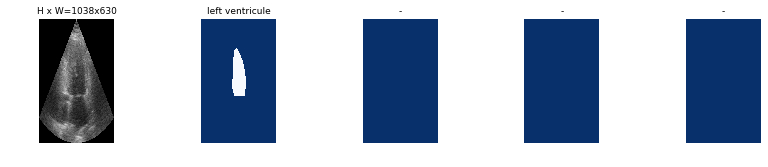

778
image mean: 38.51618
/floyd/input
mask direction/floyd/input/camus_separated/patient0230/patient0230_4CH_ED_gt1.mhd
path/floyd/input/camus_separated/patient0230/patient0230_4CH_ED.mhd
infopatient0230/patient
shape(844, 450)
(844, 450, 1)
mask shape(844, 450, 1)


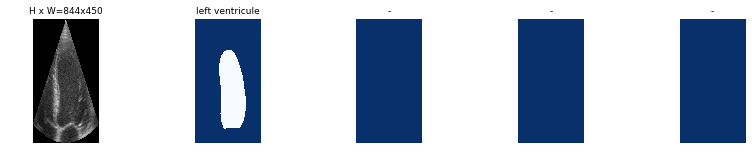

In [3]:
dataset_dir = "/floyd/input"
dataset_train = CamusDataset()
dataset_train.load_camus_images(dataset_dir,"train")
dataset_train.prepare()

# Validation dataset
dataset_val = CamusDataset()
dataset_val.load_camus_images(dataset_dir, "validation")
dataset_val.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

augmentation = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
            iaa.Affine(rotate=180),
            iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])
DEBUG=True
print(DEBUG)
if DEBUG:
    image_id=0
    print(dataset_train.image_ids.shape)
    print(dataset_train.image_ids[0])
    print(dataset_train.image_ids[-1])
    im=dataset_train.load_image(image_id)
    print("image shape:"+str(im.shape))
    m,c = dataset_train.load_mask(image_id)
    print("mask shape:"+str(m.shape))
image_ids = np.random.choice(dataset_train.image_ids, 4)
print(dataset_train.image_ids)
for image_id in image_ids:
    print(image_id)
    image = dataset_train.load_image(image_id)
    print("image mean: "+str(np.mean(image)))
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image.shape)
    print("mask shape"+str(mask.shape))
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)       


In [4]:

mean=[]
count=0
for image in dataset_train.image_ids:
    mean.append(np.mean(dataset_train.load_image(image)))
    count+=1
for im in dataset_val.image_ids:
    mean.append(np.mean(dataset_val.load_image(im)))
    count+=1
print(np.mean(mean))#mean 49.085747 

49.085747


In [6]:
width=[]
widthMax=0
HeightMin=0
height=[]
for image in dataset_train.image_ids:
    h=dataset_train.load_image(image).shape[0]
    height.append(h)
    if h<HeightMin:
        HeightMin=h
    w=dataset_train.load_image(image).shape[1]
    width.append(w)
    if widthMax<w:
        widthMax=w
for image in dataset_val.image_ids:
    h=dataset_train.load_image(image).shape[0]
    height.append(h)
    if h<HeightMin:
        HeightMin=h
    w=dataset_train.load_image(image).shape[1]
    width.append(w)
    if widthMax<w:
        widthMax=w
print("mean height: "+str(np.mean(height)))
print("mean width: "+str(np.mean(width)))
print("max width: "+str(widthMax))
print("min height: "+str(widthMax))

mean height: 984.3422222222222
mean width: 600.3622222222223
max width: 1181
min height: 1181
